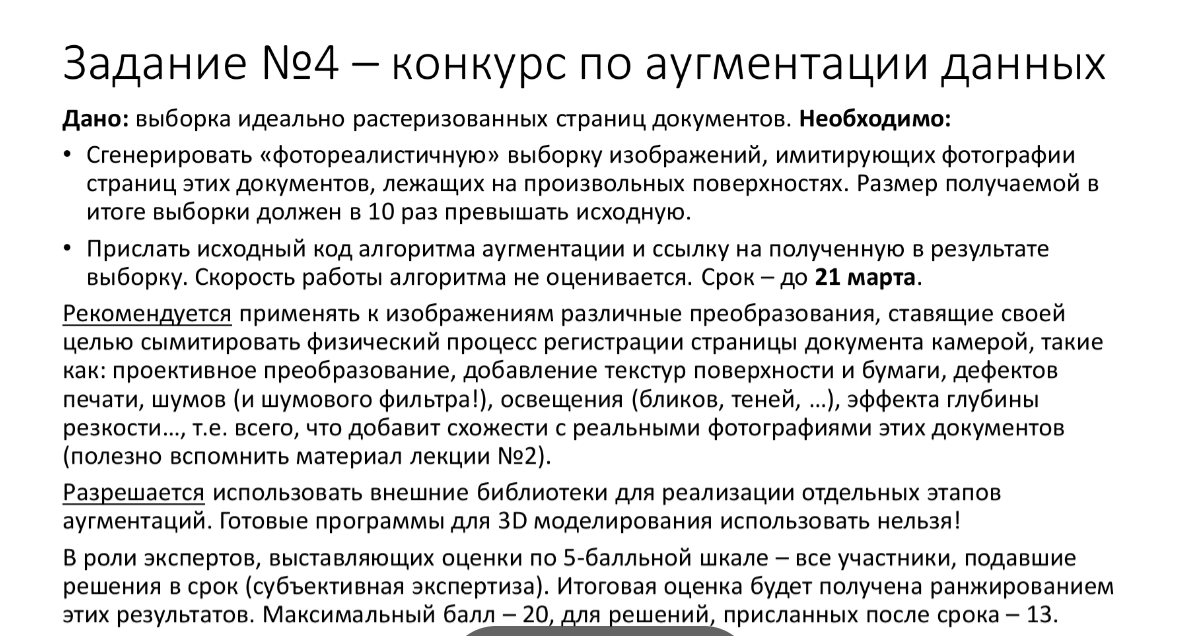

In [239]:
import cv2
import numpy as np
import random
import os
from tqdm import tqdm

from cv_methods import image_to_array, array_to_image

input_folder = "images/input/"
output_folder = "images/augmented/"
paper_folder = "images/texture_paper/"
background_folder = "images/texture_background/"

cv2.__version__

'4.6.0'

Буду использовать следующие техники:
1. Накладываю текст на бумагу (случайная текстура) с искажениями при печати (случайный поворот и смещение на 10 градусов)
2. Накладываю бумагу на поверхность (дерево / кирпич / бетон / обои)
3. Добавляю случайную тень / блик
4. Создаю перспективное искажение
5. Накладываю цифровые шумы / ухудшения резкости / смаз

In [187]:
def make_aplha(input: cv2.Mat) -> cv2.Mat:
    if input.shape[2] == 3:
        result = cv2.cvtColor(input, cv2.COLOR_BGR2BGRA)
    else:
        result = input
    return result

def open_image(name) -> cv2.Mat:
    image = cv2.imread(name)
    if image is None:
        raise ValueError("Ошибка чтения файла " + name)
    return image

def print_distortion(input: cv2.Mat) -> cv2.Mat:
    ## Имитация искажения печати: при печати бумага может не ровно податься в отделение для печати, 
    # поэтому возможны небольшие повороты изображения. 
    # Это мешает использовать геометрию листа бумаги для точного определения направляющих текста

    # Изменение масштаба для создания пространства для поворота и сдвига
    h, w, _ = input.shape
    resized = cv2.resize(input, (int(0.9 * w), int(0.9 * h)))
    h_resized, w_resized, _ = resized.shape

    image = np.ones_like(input)*255
    yoff = round((h-h_resized)/2)
    xoff = round((w-w_resized)/2)
    image[yoff:yoff+h_resized, xoff:xoff+w_resized] = resized

    # Случайный поворот
    angle = np.random.uniform(-2, 2)
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    # Случайный сдвиг
    tx = np.random.uniform(-w * 0.01, w * 0.01)
    ty = np.random.uniform(-h * 0.01, h * 0.01)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    shifted = cv2.warpAffine(rotated, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    return shifted

def paper_texture_addition(input: cv2.Mat, texture: cv2.Mat, paper_weight=0.5) -> cv2.Mat:
    texture = cv2.resize(texture, (input.shape[1], input.shape[0]))
    result = cv2.addWeighted(input, 1 - paper_weight, texture, paper_weight, 0)

    return result

def background_texture_addition(input: cv2.Mat, texture: cv2.Mat) -> cv2.Mat:
    # Изменение масштаба для создания пространства для поворота и сдвига
    h, w, _ = input.shape
    scale = np.random.uniform(0.3, 0.5)
    # Случайный масштаб   
    resized = cv2.resize(input, None, fx=scale, fy=scale)
    h, w, _ = resized.shape

    # Увеличение до размера текстуры
    hh, ww, _ = texture.shape
    image = np.zeros((hh, ww, 4))
    yoff = round((hh-h)/2)
    xoff = round((ww-w)/2)
    image[yoff:yoff+h, xoff:xoff+w] = make_aplha(resized)
    w = ww
    h = hh

    image = make_aplha(image)

    # Случайный поворот
    angle = np.random.uniform(-10, 10)
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

    # Случайный сдвиг
    tx = np.random.uniform(-w * 0.2, w * 0.2)
    ty = np.random.uniform(-h * 0.2, h * 0.2)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    shifted = cv2.warpAffine(rotated, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

    # separate alpha and color channels from the foreground image
    foreground_colors = shifted[:, :, :3]
    alpha_channel = shifted[:, :, 3] / 255  # 0-255 => 0.0-1.0

    # construct an alpha_mask that matches the image shape
    alpha_mask = np.dstack((alpha_channel, alpha_channel, alpha_channel))

    # combine the background with the overlay image weighted by alpha
    composite = texture * (1 - alpha_mask) + foreground_colors * alpha_mask

    return composite

def random_perspective(input: cv2.Mat, margin=0.2) -> cv2.Mat:
    perspective1 = np.random.randint(0, 100) / 100 * margin
    perspective2 = np.random.randint(0, 100) / 100 * margin

    h, w = input.shape[:2]

    src_points = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
    dst_points = np.float32([[int(perspective1 * w), 0], [int((1 - perspective1) * w), 0], [0, h], [w, h]])
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    perspective_image = cv2.warpPerspective(input, matrix, (w, h))

    src_points = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
    dst_points = np.float32([[0, int(perspective2 * h)], [w, 0], [0, int((1 - perspective2) * h)], [w, h]])
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    perspective_image = cv2.warpPerspective(input, matrix, (w, h))
    perspective_image = perspective_image[int(margin * h):int((1 - margin) * h), int(margin * w):int((1 - margin) * w)]

    return perspective_image

In [253]:
def generate_augmented(input, prefix, destination_folder, get_paper_func, get_back_func, n=10):
    for i in tqdm(range(n), position=0, desc="augmentation creation for " + prefix, leave=False, colour='green', ncols=80):
        printed = print_distortion(input)
        printed_on_paper = paper_texture_addition(printed, get_paper_func())
        on_background = background_texture_addition(printed_on_paper, get_back_func())
        perspectived = random_perspective(on_background)
        blured = cv2.blur(perspectived, (np.random.randint(1, 5), np.random.randint(1, 5)))
        # Добавьте шум к изображению
        noise = np.zeros_like(blured)
        cv2.randn(noise, 0, 25)
        noisy = cv2.add(blured, noise)
    
        cv2.imwrite(destination_folder + prefix + '_' + str(i + 1) + '.png', noisy)
    print("created for " + prefix + "!")

In [222]:
def get_paper_func():
    name = np.random.choice([name for name in os.listdir(paper_folder) if name.endswith(".jpeg")])
    return open_image(paper_folder + name)

def get_back_func():
    name = np.random.choice([name for name in os.listdir(background_folder) if name.endswith(".jpeg")])
    return open_image(background_folder + name)

In [254]:
for i, image_name in enumerate(os.listdir(input_folder)):
    generate_augmented(open_image(input_folder + image_name), image_name, output_folder, get_paper_func, get_back_func, 10)

created for 8.png!


created for 9.png!


created for 10.png!


created for 4.png!


created for 5.png!


created for 7.png!


created for 6.png!


created for 2.png!


created for 3.png!


                                                                                3.40s/it]

created for 1.png!
